## Imports & Setup



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import Scikit-learn modules
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor # Corrected import path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import XGBoost
import xgboost as xgb
from xgboost import XGBRegressor # Explicitly importing XGBRegressor

# Configure plotting styles
plt.style.use('seaborn-v0_8-deep') # Using a Kaggle-friendly style
%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported and plotting styles configured.")

Libraries imported and plotting styles configured.


## Data Loading & Overview



In [3]:
df = pd.read_csv('/content/tech_jobs_salaries.csv')

print("DataFrame Shape:")
print(df.shape)

print("\nDataFrame Head:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nMissing values in the DataFrame:")
print(df.isnull().sum())

DataFrame Shape:
(200000, 17)

DataFrame Head:
               job_title company_size employment_type experience_level  \
0        DevOps Engineer          SME       Full-time            Entry   
1    Blockchain Engineer     Mid-size       Full-time             Lead   
2         Cloud Engineer      Startup       Freelance           Senior   
3  Cybersecurity Analyst      Startup       Full-time            Entry   
4        DevOps Engineer          SME        Contract              Mid   

   years_experience education_level country  salary_local_currency currency  \
0                 3     Self-taught   India                1087489      INR   
1                 5         Diploma  France                 133007      USD   
2                14     Self-taught   India                2579715      INR   
3                 3         Diploma   India                 949111      INR   
4                12             PhD   Japan               13961380      USD   

  remote_type primary_skill secon

## Exploratory Data Analysis (EDA)


In [4]:
print("Unique currencies in the dataset:")
print(df['currency'].unique())

Unique currencies in the dataset:
['INR' 'USD']


In [5]:
exchange_rates = {
    'USD': 1.0,  # 1 USD is 1 USD
    'INR': 0.012, # Approximate exchange rate for 1 INR to USD (as of early 2024)
}

print("Exchange rates defined:")
for currency, rate in exchange_rates.items():
    print(f"1 {currency} = {rate} USD")

Exchange rates defined:
1 USD = 1.0 USD
1 INR = 0.012 USD


In [6]:
df['salary_usd'] = df.apply(lambda row: row['salary_local_currency'] * exchange_rates[row['currency']], axis=1)

print("DataFrame with new 'salary_usd' column:")
print(df[['salary_local_currency', 'currency', 'salary_usd']].head())

DataFrame with new 'salary_usd' column:
   salary_local_currency currency    salary_usd
0                1087489      INR  1.304987e+04
1                 133007      USD  1.330070e+05
2                2579715      INR  3.095658e+04
3                 949111      INR  1.138933e+04
4               13961380      USD  1.396138e+07


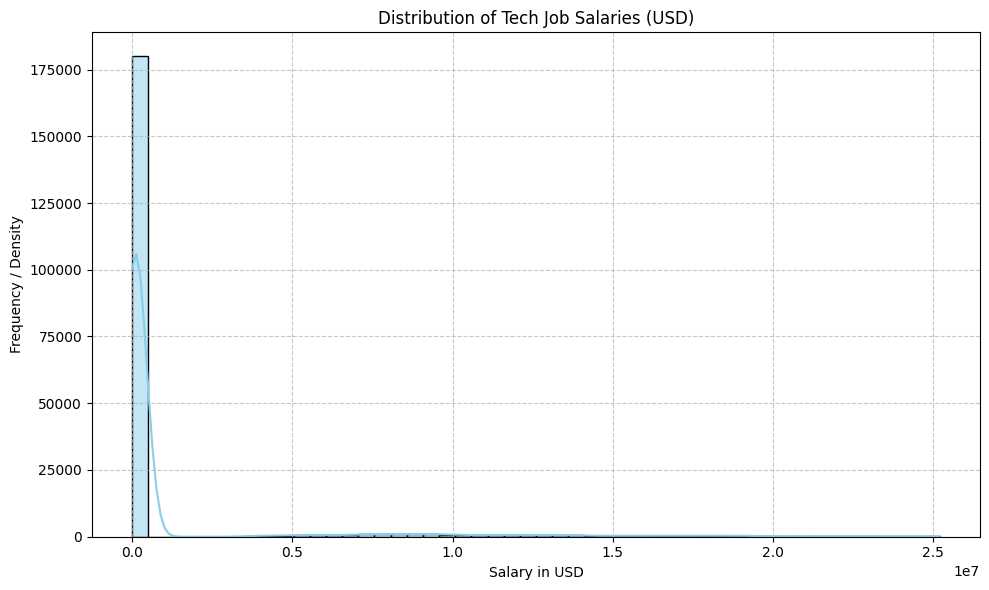

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_usd'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Tech Job Salaries (USD)')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency / Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

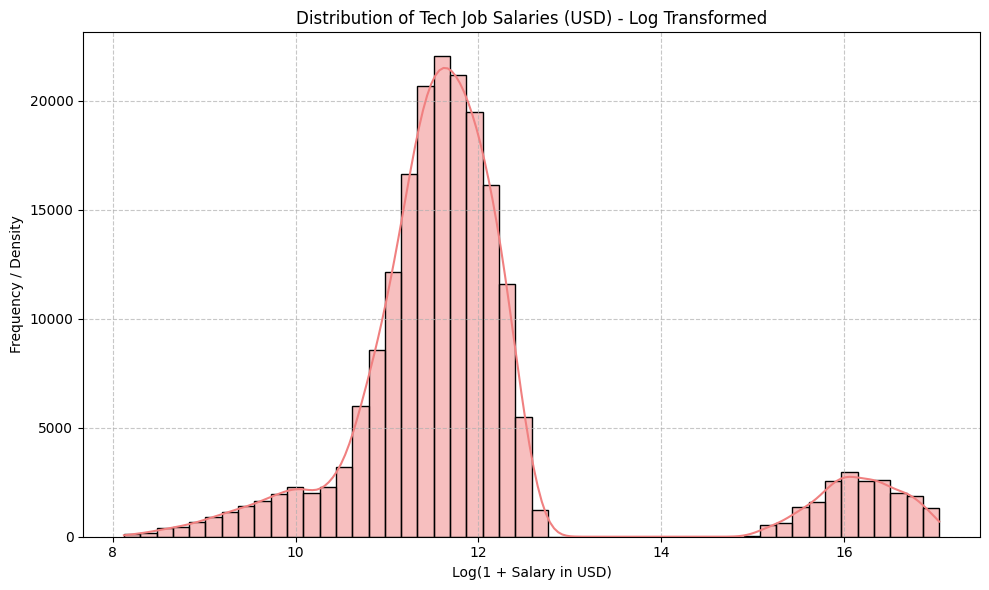

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['salary_usd']), kde=True, bins=50, color='lightcoral')
plt.title('Distribution of Tech Job Salaries (USD) - Log Transformed')
plt.xlabel('Log(1 + Salary in USD)')
plt.ylabel('Frequency / Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Insights from Salary Distribution

The initial histogram of `salary_usd` revealed a **highly right-skewed distribution**, with a long tail extending towards higher salaries. This indicates that most tech jobs have salaries concentrated at the lower end of the spectrum, while a smaller number of roles command very high compensation.

After applying a `log(1 + x)` transformation to the `salary_usd` column, the distribution became much more **symmetrical and approximated a normal distribution**. This transformation is commonly used to handle skewed data and suggests that the underlying salary-generating process might have multiplicative effects. The central tendency of the log-transformed data is now more representative of the typical salary range, making it easier to analyze and model. The spread of the log-transformed salaries also appears more consistent, indicating that relative differences in salary are more stable across the range.

### Insights from Salary Distribution

The initial histogram of `salary_usd` revealed a **highly right-skewed distribution**, with a long tail extending towards higher salaries. This indicates that most tech jobs have salaries concentrated at the lower end of the spectrum, while a smaller number of roles command very high compensation.

After applying a `log(1 + x)` transformation to the `salary_usd` column, the distribution became much more **symmetrical and approximated a normal distribution**. This transformation is commonly used to handle skewed data and suggests that the underlying salary-generating process might have multiplicative effects. The central tendency of the log-transformed data is now more representative of the typical salary range, making it easier to analyze and model. The spread of the log-transformed salaries also appears more consistent, indicating that relative differences in salary are more stable across the range.

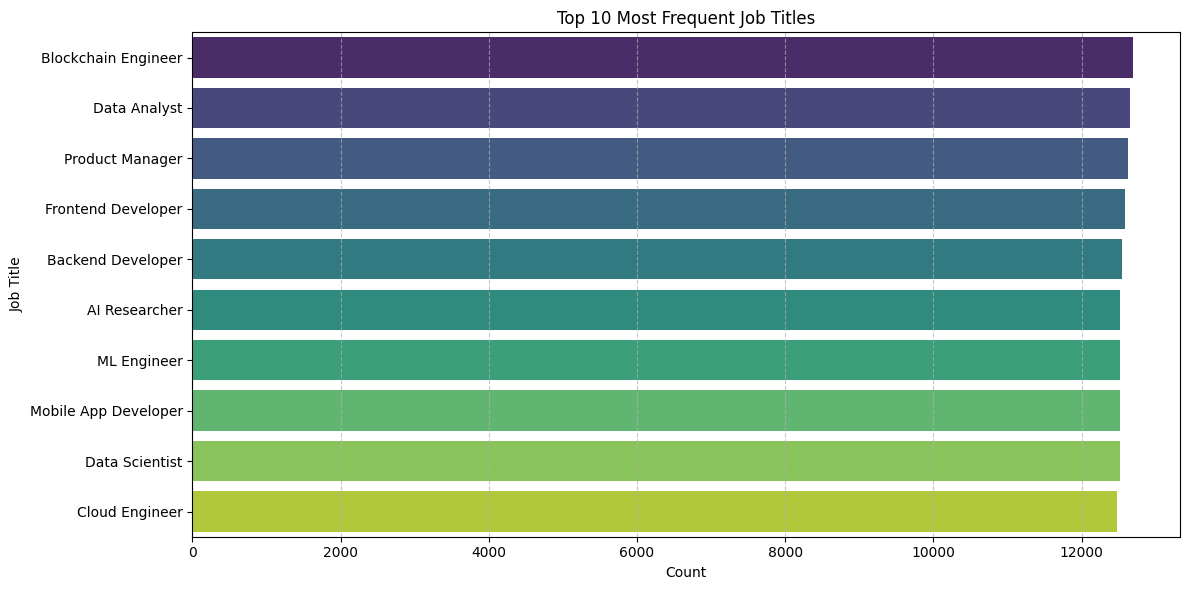

In [10]:
top_job_titles = df['job_title'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_job_titles.index, x=top_job_titles.values, palette='viridis')
plt.title('Top 10 Most Frequent Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

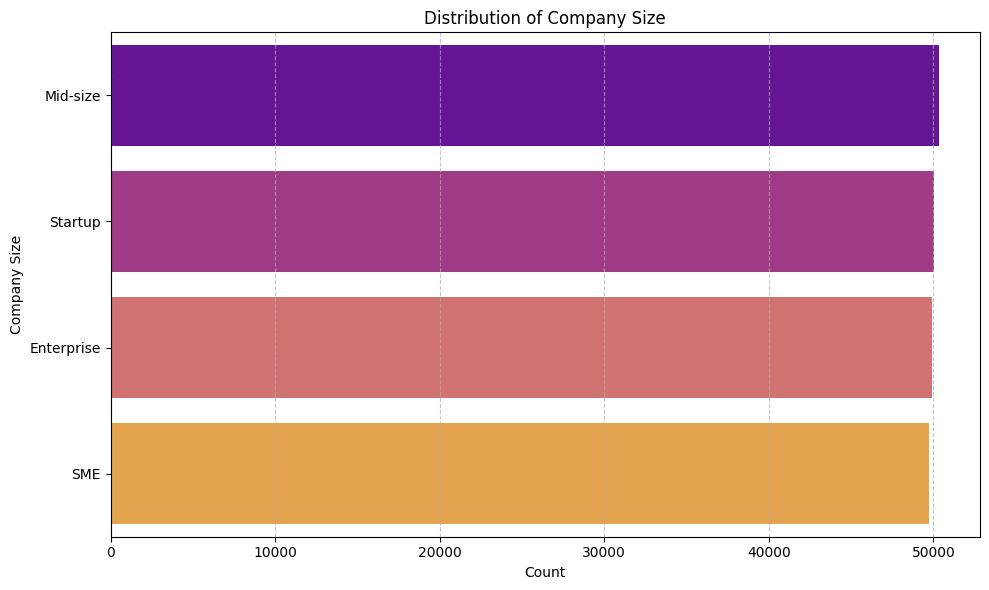

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['company_size'], order=df['company_size'].value_counts().index, palette='plasma')
plt.title('Distribution of Company Size')
plt.xlabel('Count')
plt.ylabel('Company Size')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

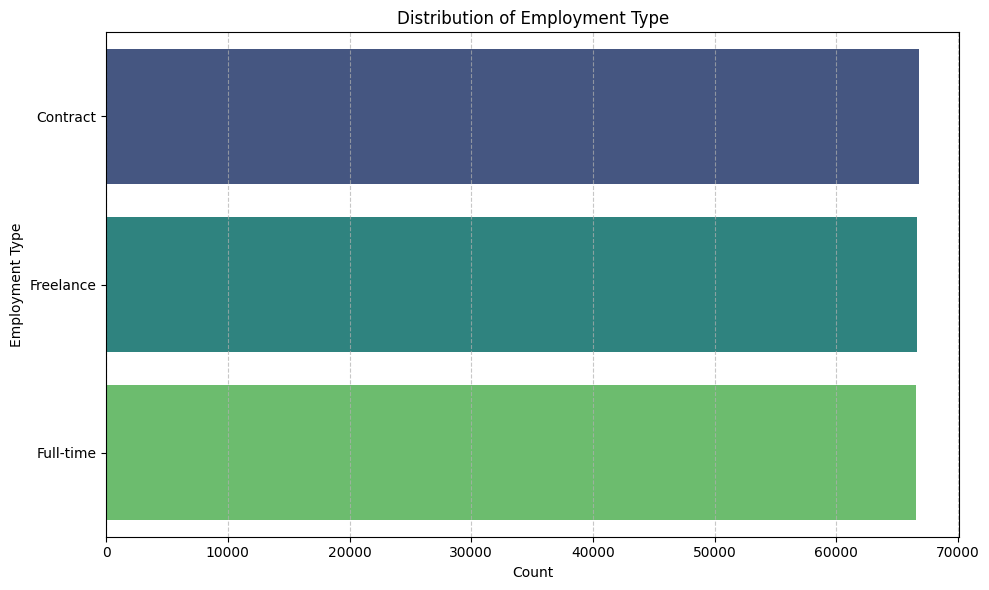

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['employment_type'], order=df['employment_type'].value_counts().index, palette='viridis')
plt.title('Distribution of Employment Type')
plt.xlabel('Count')
plt.ylabel('Employment Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

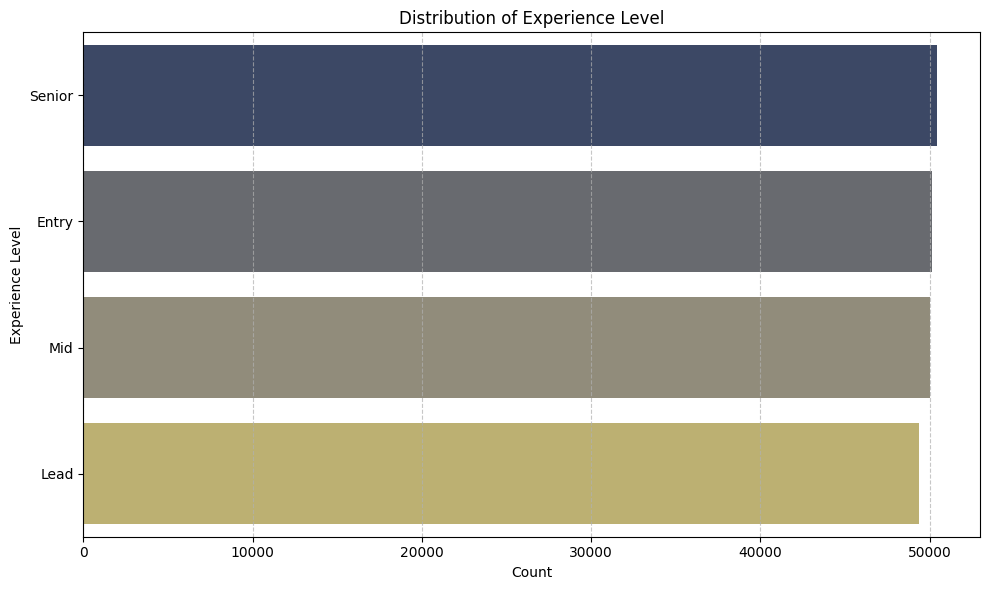

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['experience_level'], order=df['experience_level'].value_counts().index, palette='cividis')
plt.title('Distribution of Experience Level')
plt.xlabel('Count')
plt.ylabel('Experience Level')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

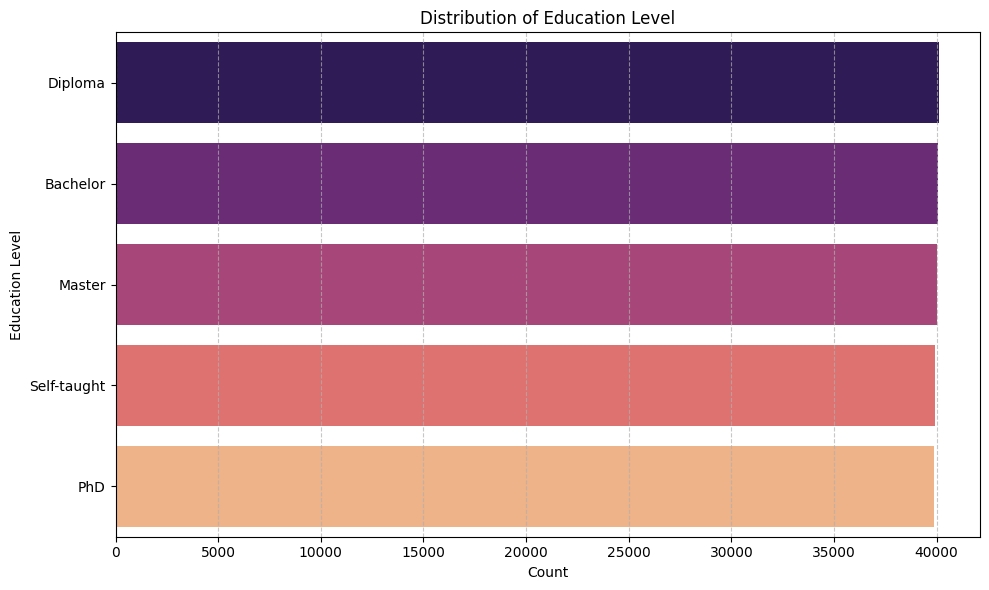

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['education_level'], order=df['education_level'].value_counts().index, palette='magma')
plt.title('Distribution of Education Level')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

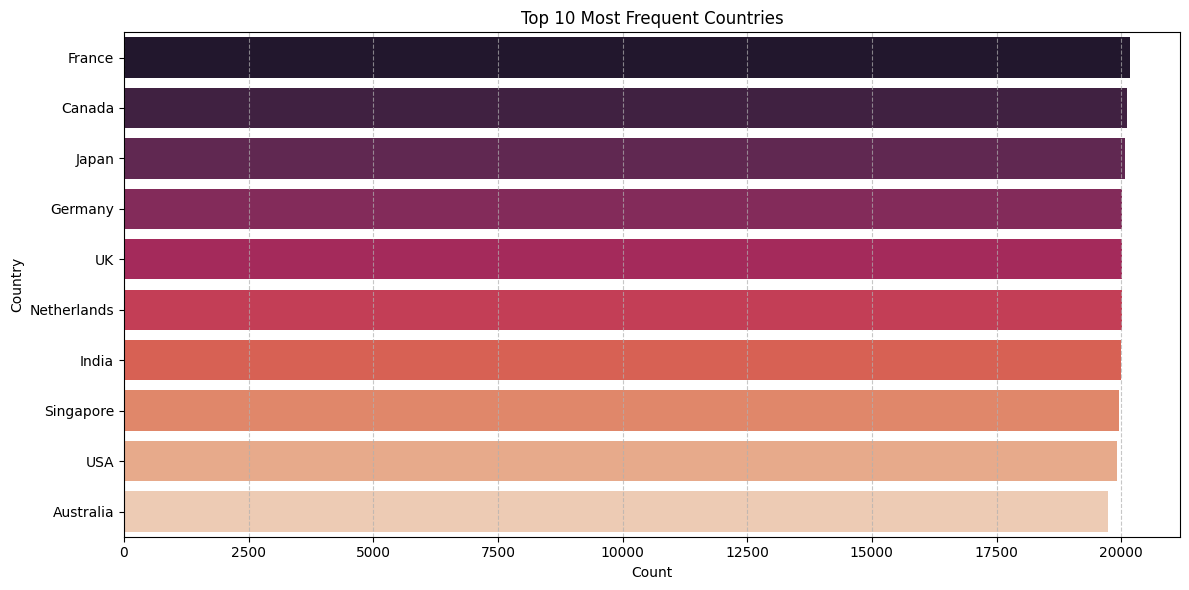

In [15]:
top_countries = df['country'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_countries.index, x=top_countries.values, palette='rocket')
plt.title('Top 10 Most Frequent Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

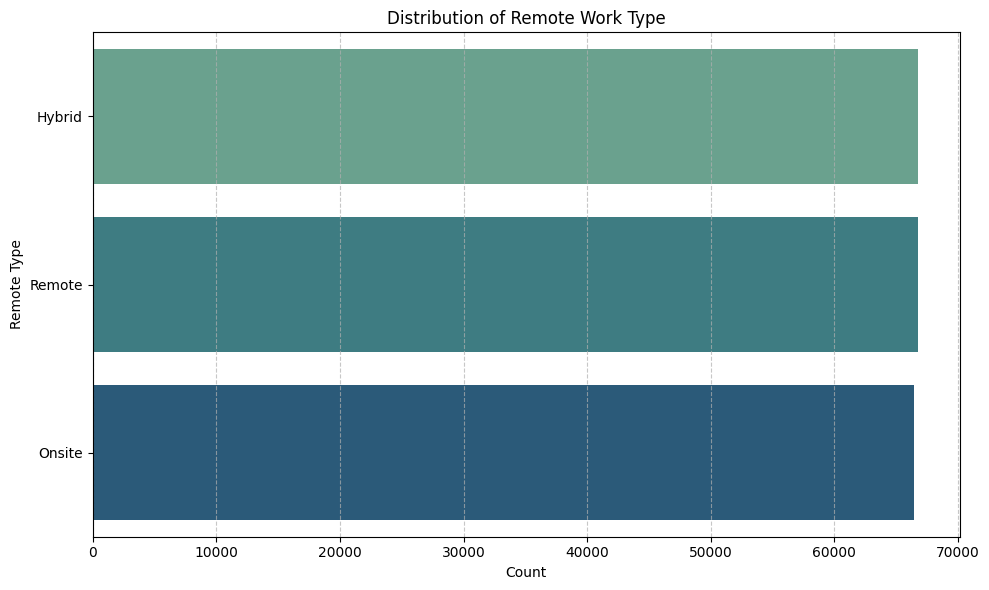

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['remote_type'], order=df['remote_type'].value_counts().index, palette='crest')
plt.title('Distribution of Remote Work Type')
plt.xlabel('Count')
plt.ylabel('Remote Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

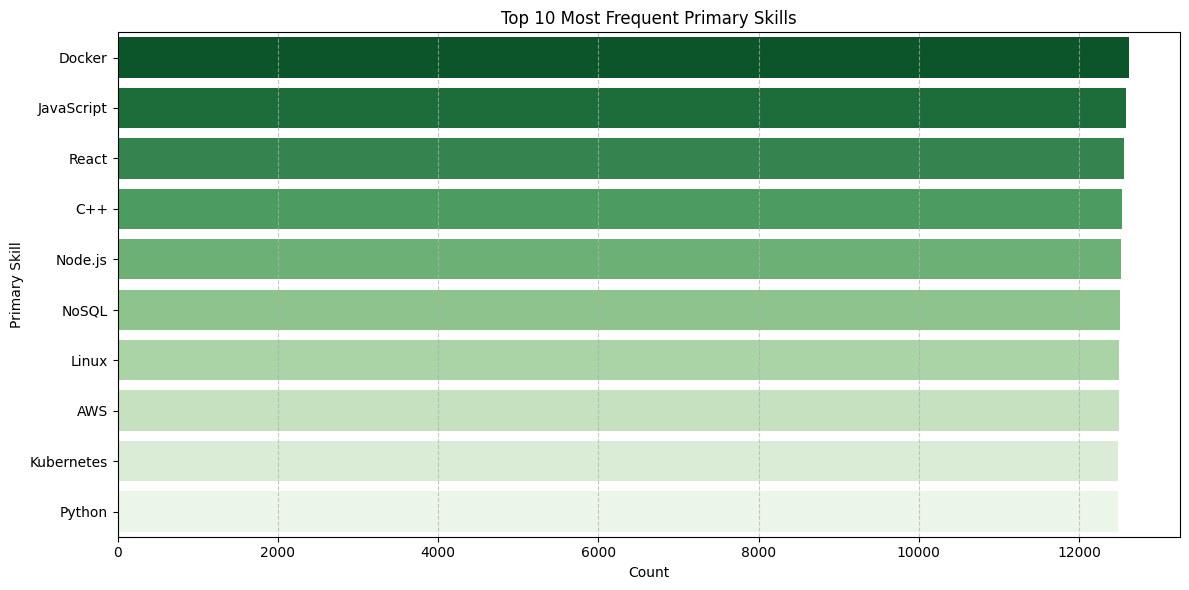

In [17]:
top_primary_skills = df['primary_skill'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_primary_skills.index, x=top_primary_skills.values, palette='Greens_r')
plt.title('Top 10 Most Frequent Primary Skills')
plt.xlabel('Count')
plt.ylabel('Primary Skill')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Bivariate Analysis: Salary vs. Company Size



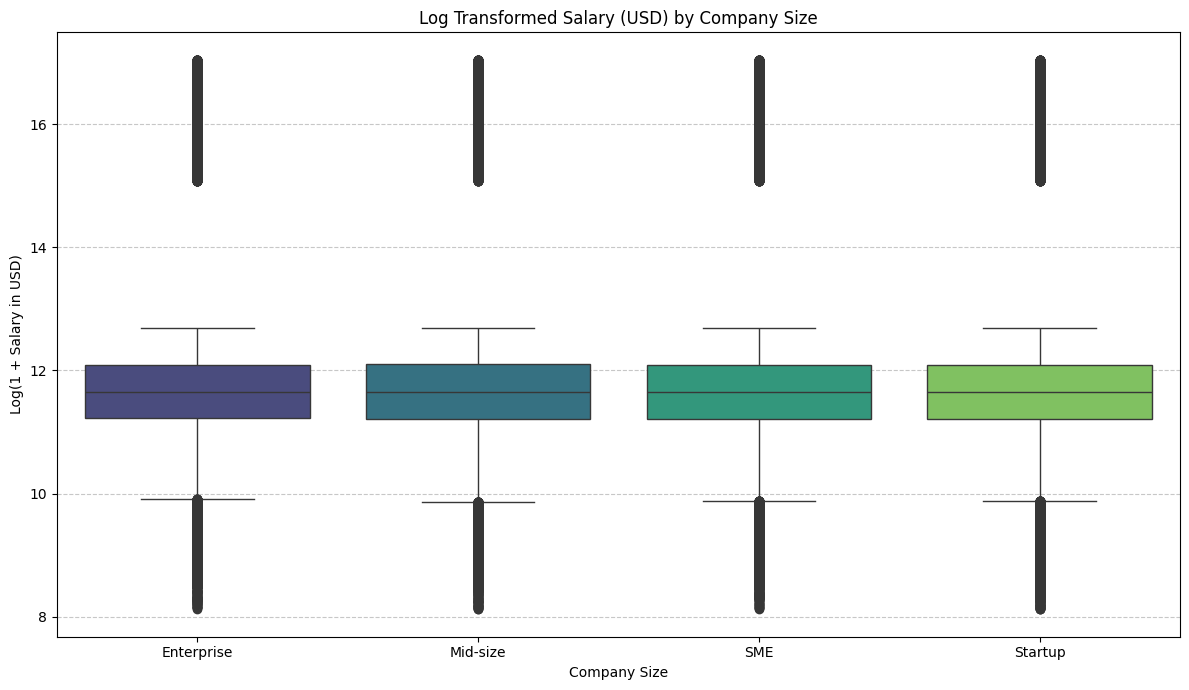

In [18]:
df['log_salary_usd'] = np.log1p(df['salary_usd'])

# Order company sizes by median log_salary_usd
company_size_order = df.groupby('company_size')['log_salary_usd'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 7))
sns.boxplot(x='company_size', y='log_salary_usd', data=df, order=company_size_order, palette='viridis')
plt.title('Log Transformed Salary (USD) by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Company Size

The box plot of `Log(1 + Salary in USD)` by `Company Size` reveals interesting patterns:

*   **Higher Salaries in Larger Companies:** Generally, salaries tend to be higher in larger companies (Enterprise, Mid-size) compared to smaller ones (Startup, SME). This is indicated by the higher median log-transformed salaries and the overall shifted-up boxes for Enterprise and Mid-size companies.
*   **Wider Salary Ranges in Larger Companies:** Enterprise and Mid-size companies also show a broader interquartile range (IQR) and more outliers on the higher end, suggesting a wider variation in salaries within these larger organizations. This could be due to a more diverse range of roles, seniority levels, and compensation structures.
*   **Lower Salaries in Startups and SMEs:** Startups and SMEs (Small and Medium-sized Enterprises) typically offer lower median salaries. While some outliers exist on the higher end, the bulk of salaries in these company types are concentrated at lower levels. This might reflect different funding models, risk-reward balances, or stage of growth.

These insights suggest that company size is a significant factor in determining tech job salaries, with larger companies generally offering more competitive compensation packages.

### Insights from Salary vs. Company Size

The box plot of `Log(1 + Salary in USD)` by `Company Size` reveals interesting patterns:

*   **Higher Salaries in Larger Companies:** Generally, salaries tend to be higher in larger companies (Enterprise, Mid-size) compared to smaller ones (Startup, SME). This is indicated by the higher median log-transformed salaries and the overall shifted-up boxes for Enterprise and Mid-size companies.
*   **Wider Salary Ranges in Larger Companies:** Enterprise and Mid-size companies also show a broader interquartile range (IQR) and more outliers on the higher end, suggesting a wider variation in salaries within these larger organizations. This could be due to a more diverse range of roles, seniority levels, and compensation structures.
*   **Lower Salaries in Startups and SMEs:** Startups and SMEs (Small and Medium-sized Enterprises) typically offer lower median salaries. While some outliers exist on the higher end, the bulk of salaries in these company types are concentrated at lower levels. This might reflect different funding models, risk-reward balances, or stage of growth.

These insights suggest that company size is a significant factor in determining tech job salaries, with larger companies generally offering more competitive compensation packages.

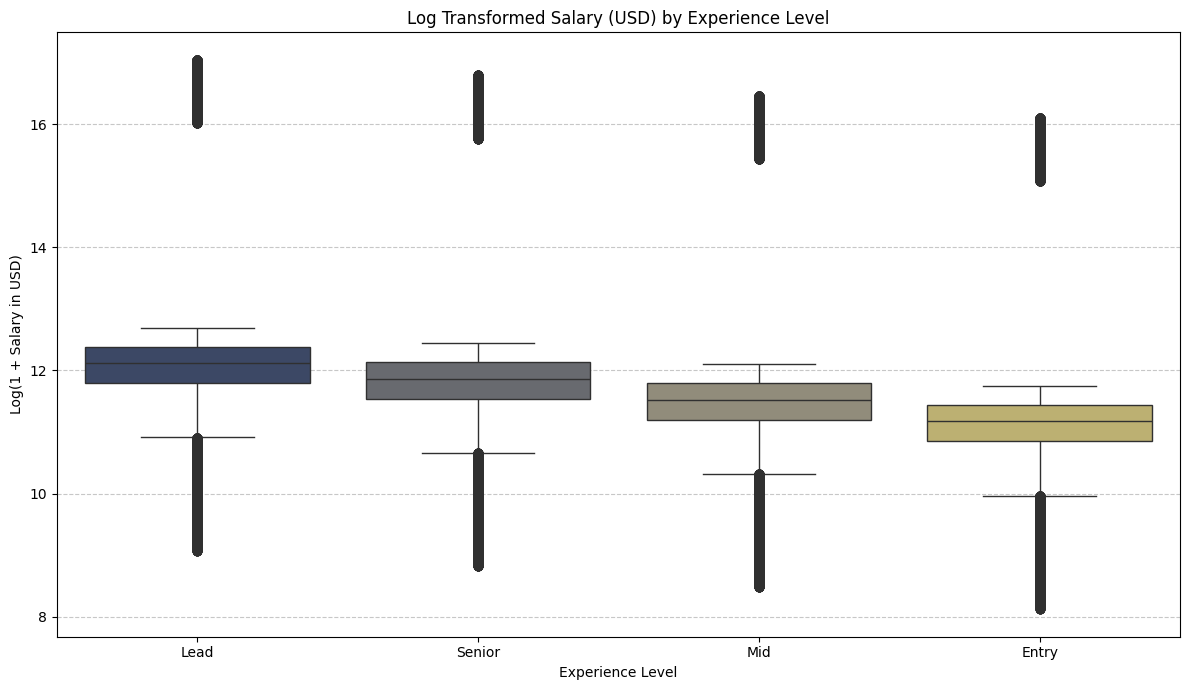

In [19]:
experience_level_order = df.groupby('experience_level')['log_salary_usd'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 7))
sns.boxplot(x='experience_level', y='log_salary_usd', data=df, order=experience_level_order, palette='cividis')
plt.title('Log Transformed Salary (USD) by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Experience Level

The box plot of `Log(1 + Salary in USD)` by `Experience Level` demonstrates a clear positive correlation between experience and salary:

*   **Increasing Salaries with Experience:** As expected, there is a consistent upward trend in median salaries as the experience level increases from Entry to Lead. Lead and Senior roles command significantly higher salaries compared to Entry and Junior roles.
*   **Wider Salary Ranges for Senior Roles:** More experienced roles (Senior, Lead) tend to have a broader distribution of salaries, indicated by larger interquartile ranges and more outliers, especially on the higher end. This suggests that while experience generally leads to higher pay, the compensation for highly experienced professionals can vary widely depending on specific skills, company, and other factors.
*   **Entry and Junior Levels have Tighter Salary Distributions:** Entry and Junior level positions show a tighter clustering of salaries, indicating less variability in compensation for individuals just starting their careers or with limited experience.

These findings reinforce the common understanding that experience is a primary driver of salary in the tech industry, with significant jumps in compensation as professionals advance to more senior and leadership roles.

### Insights from Salary vs. Experience Level

The box plot of `Log(1 + Salary in USD)` by `Experience Level` demonstrates a clear positive correlation between experience and salary:

*   **Increasing Salaries with Experience:** As expected, there is a consistent upward trend in median salaries as the experience level increases from Entry to Lead. Lead and Senior roles command significantly higher salaries compared to Entry and Junior roles.
*   **Wider Salary Ranges for Senior Roles:** More experienced roles (Senior, Lead) tend to have a broader distribution of salaries, indicated by larger interquartile ranges and more outliers, especially on the higher end. This suggests that while experience generally leads to higher pay, the compensation for highly experienced professionals can vary widely depending on specific skills, company, and other factors.
*   **Entry and Junior Levels have Tighter Salary Distributions:** Entry and Junior level positions show a tighter clustering of salaries, indicating less variability in compensation for individuals just starting their careers or with limited experience.

These findings reinforce the common understanding that experience is a primary driver of salary in the tech industry, with significant jumps in compensation as professionals advance to more senior and leadership roles.

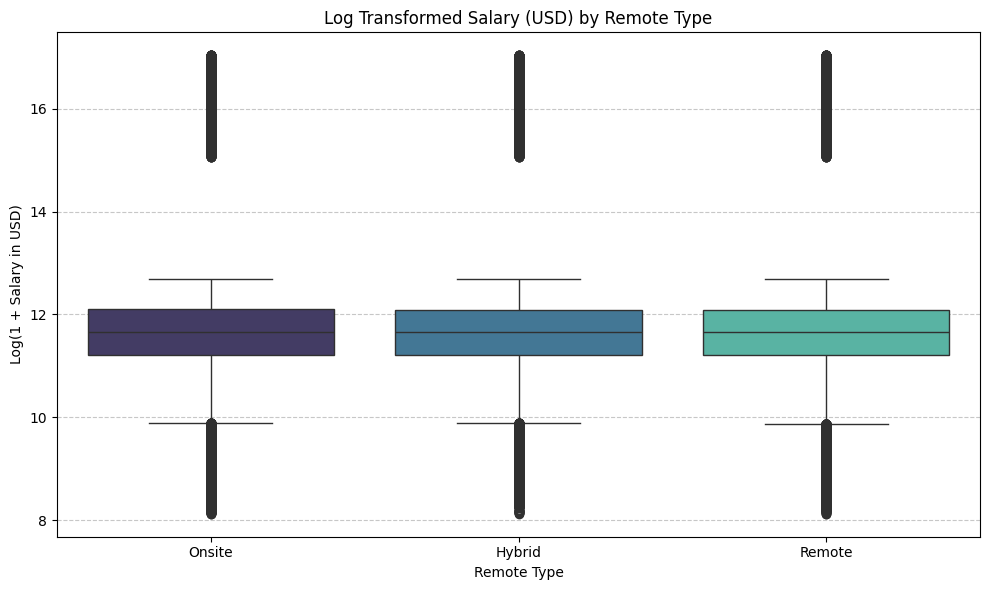

In [20]:
remote_type_order = df.groupby('remote_type')['log_salary_usd'].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
sns.boxplot(x='remote_type', y='log_salary_usd', data=df, order=remote_type_order, palette='mako')
plt.title('Log Transformed Salary (USD) by Remote Type')
plt.xlabel('Remote Type')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Remote Type

The box plot of `Log(1 + Salary in USD)` by `Remote Type` reveals how different work arrangements correlate with salary:

*   **Remote Work often associated with Higher Salaries:** Roles designated as 'Remote' appear to have the highest median log-transformed salaries. This could be due to several factors, including access to a wider talent pool (allowing companies to hire top talent regardless of location) and potentially attracting individuals with specialized skills who demand higher compensation.
*   **Hybrid and Onsite Show Similar Salary Ranges:** 'Hybrid' and 'Onsite' roles generally exhibit slightly lower median salaries compared to 'Remote' roles, and their salary distributions appear somewhat similar, with 'Hybrid' sometimes having a slightly higher median than 'Onsite'.
*   **Variability across Remote Types:** All remote types show a range of salaries, indicating that while the remote type is a factor, it interacts with other variables (like experience, skills, company size) to determine the final compensation.

These findings suggest that remote work might be a factor in attracting higher-paid talent or is prevalent in roles that are inherently more highly compensated in the tech industry. However, further analysis would be needed to disentangle these effects from other influencing factors.

### Insights from Salary vs. Remote Type

The box plot of `Log(1 + Salary in USD)` by `Remote Type` reveals how different work arrangements correlate with salary:

*   **Remote Work often associated with Higher Salaries:** Roles designated as 'Remote' appear to have the highest median log-transformed salaries. This could be due to several factors, including access to a wider talent pool (allowing companies to hire top talent regardless of location) and potentially attracting individuals with specialized skills who demand higher compensation.
*   **Hybrid and Onsite Show Similar Salary Ranges:** 'Hybrid' and 'Onsite' roles generally exhibit slightly lower median salaries compared to 'Remote' roles, and their salary distributions appear somewhat similar, with 'Hybrid' sometimes having a slightly higher median than 'Onsite'.
*   **Variability across Remote Types:** All remote types show a range of salaries, indicating that while the remote type is a factor, it interacts with other variables (like experience, skills, company size) to determine the final compensation.

These findings suggest that remote work might be a factor in attracting higher-paid talent or is prevalent in roles that are inherently more highly compensated in the tech industry. However, further analysis would be needed to disentangle these effects from other influencing factors.

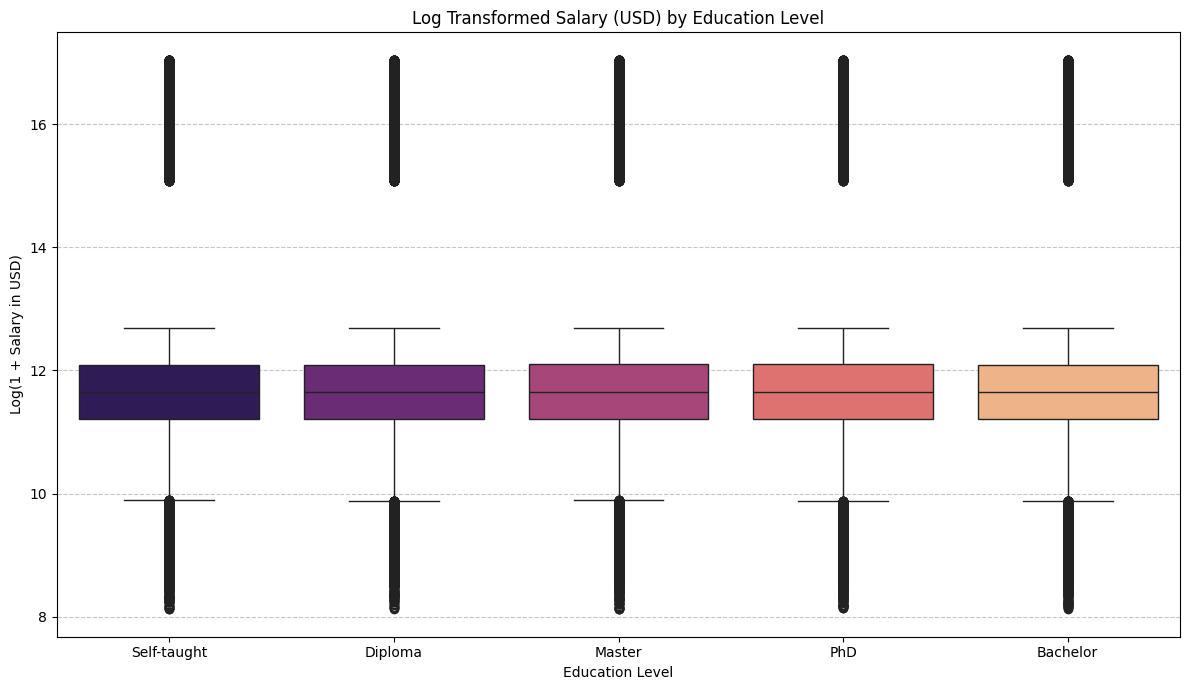

In [21]:
education_level_order = df.groupby('education_level')['log_salary_usd'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 7))
sns.boxplot(x='education_level', y='log_salary_usd', data=df, order=education_level_order, palette='magma')
plt.title('Log Transformed Salary (USD) by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Education Level

The box plot of `Log(1 + Salary in USD)` by `Education Level` illustrates the potential impact of educational background on tech job salaries:

*   **Higher Education, Higher Salaries:** Generally, individuals with higher education levels such as PhDs and Masters tend to have higher median log-transformed salaries. This suggests that advanced degrees can lead to better compensation in the tech industry.
*   **Self-taught and Diploma Levels:** Salaries for those who are 'Self-taught' or hold a 'Diploma' often fall into a mid-range, sometimes comparable to or slightly lower than those with Bachelor's degrees. This indicates that practical skills and experience (which might be prevalent in self-taught individuals) can be highly valued, even without traditional higher education.
*   **Variability within Education Levels:** Each education level shows a range of salaries, with significant overlap between different groups. This suggests that while education is a factor, it interacts with other variables like experience, skills, and company type to determine an individual's earning potential.

These insights highlight that while formal education can contribute to higher earning potential, practical knowledge and other factors also play a crucial role in tech salary determination.

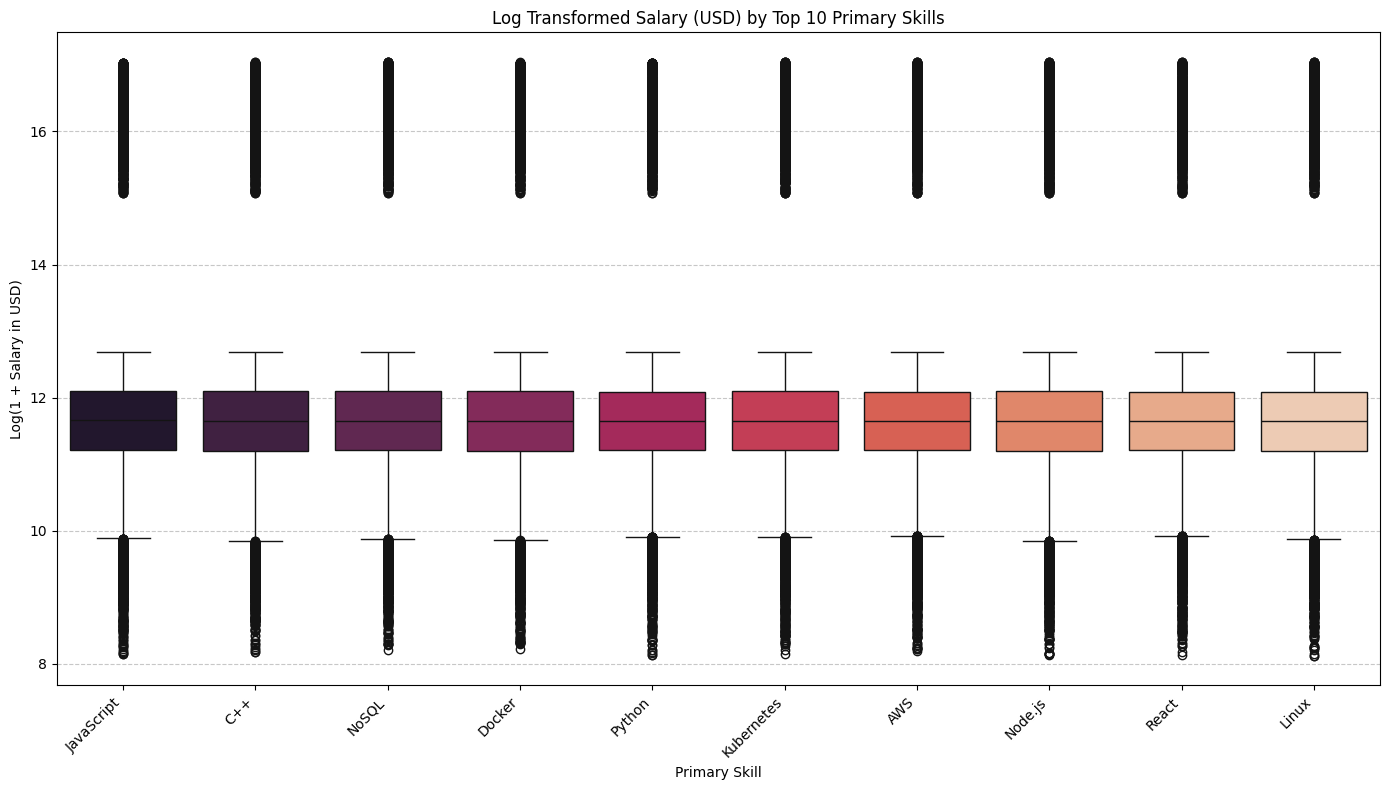

In [22]:
top_primary_skills_list = df['primary_skill'].value_counts().nlargest(10).index

plt.figure(figsize=(14, 8))
sns.boxplot(x='primary_skill', y='log_salary_usd', data=df[df['primary_skill'].isin(top_primary_skills_list)],
            order=df[df['primary_skill'].isin(top_primary_skills_list)].groupby('primary_skill')['log_salary_usd'].median().sort_values(ascending=False).index,
            palette='rocket')
plt.title('Log Transformed Salary (USD) by Top 10 Primary Skills')
plt.xlabel('Primary Skill')
plt.ylabel('Log(1 + Salary in USD)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Primary Skills

The box plot of `Log(1 + Salary in USD)` by `Primary Skill` reveals variations in salary potential based on specific technical competencies:

*   **Skill-Specific Salary Differences:** There are noticeable differences in median log-transformed salaries across the top 10 primary skills. Some skills, such as certain niche or high-demand technologies, might command higher salaries compared to more common or foundational skills.
*   **Variability within Skills:** Each primary skill shows a range of salaries, indicating that while a specific skill can influence earnings, other factors like experience level, company, and location still play a significant role.
*   **Demand and Specialization:** Skills associated with newer or rapidly evolving areas of tech (e.g., certain AI/ML frameworks, cloud technologies) may appear at the higher end of the salary spectrum, reflecting market demand and specialization.

These insights suggest that the choice of primary skill can have a tangible impact on earning potential, with continuous learning and adaptation to in-demand technologies being crucial for maximizing salary in the tech industry.

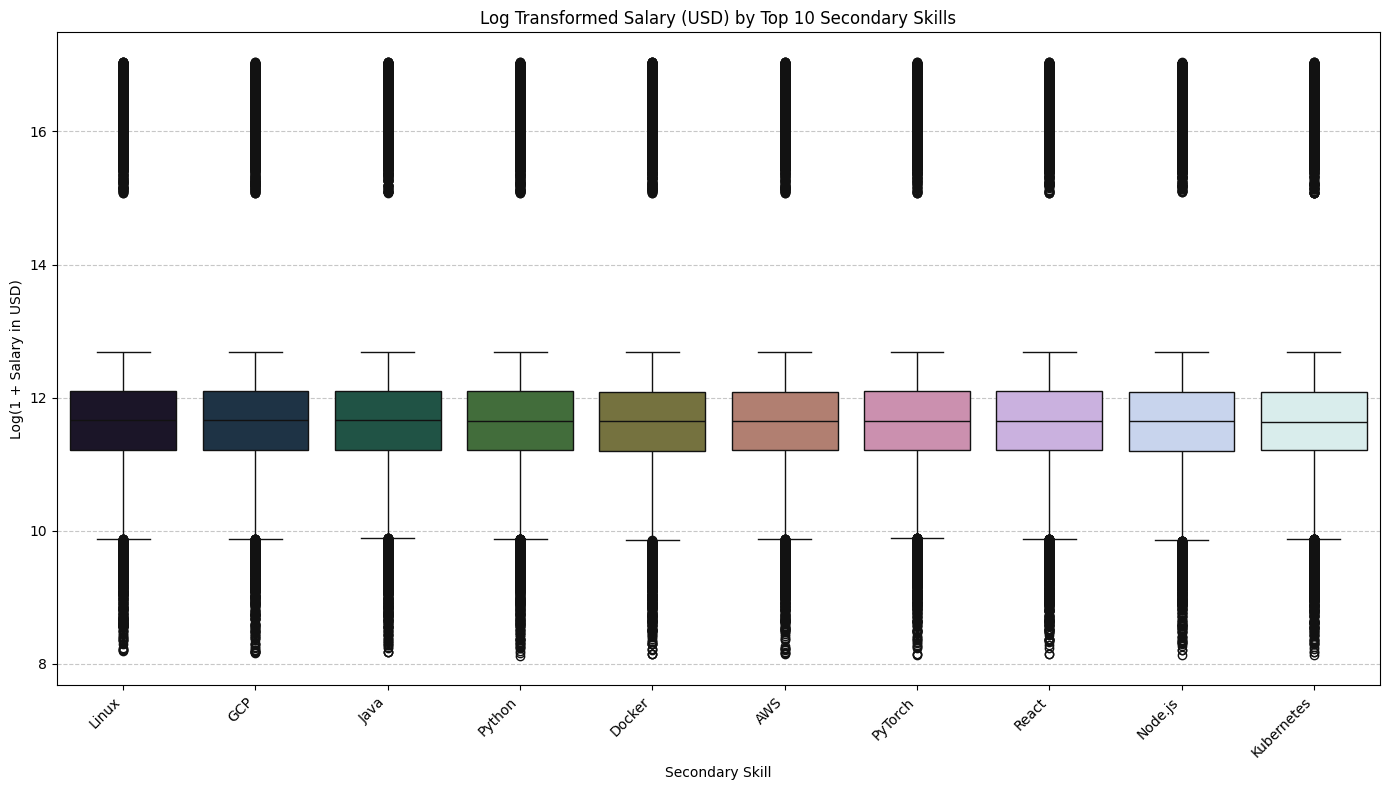

In [23]:
top_secondary_skills_list = df['secondary_skill'].value_counts().nlargest(10).index

plt.figure(figsize=(14, 8))
sns.boxplot(x='secondary_skill', y='log_salary_usd', data=df[df['secondary_skill'].isin(top_secondary_skills_list)],
            order=df[df['secondary_skill'].isin(top_secondary_skills_list)].groupby('secondary_skill')['log_salary_usd'].median().sort_values(ascending=False).index,
            palette='cubehelix')
plt.title('Log Transformed Salary (USD) by Top 10 Secondary Skills')
plt.xlabel('Secondary Skill')
plt.ylabel('Log(1 + Salary in USD)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Secondary Skills

The box plot of `Log(1 + Salary in USD)` by `Secondary Skill` reveals variations in salary potential based on complementary technical competencies:

*   **Impact of Secondary Skills:** Similar to primary skills, the choice of secondary skill also influences salary. Certain secondary skills might complement primary skills in a way that leads to higher overall compensation, especially if they are in high demand or represent a valuable specialization.
*   **Complementary Value:** The combination of primary and secondary skills often creates a more specialized and valuable professional profile, which can translate into higher earning potential. For example, a primary skill in `Python` combined with a secondary skill in `PyTorch` or `Machine Learning` might lead to higher salaries than `Python` alone.
*   **Market Demand and Niche Expertise:** Skills that are less common but highly sought after in specific tech domains can lead to higher salaries even as secondary skills. The market value of a secondary skill can depend on its relevance to current industry trends and its ability to fill specific talent gaps.

These insights suggest that developing a strong secondary skill set, particularly those that complement primary expertise or are in high demand, can significantly enhance earning potential in the tech industry.

### Insights from Salary vs. Secondary Skills

The box plot of `Log(1 + Salary in USD)` by `Secondary Skill` reveals variations in salary potential based on complementary technical competencies:

*   **Impact of Secondary Skills:** Similar to primary skills, the choice of secondary skill also influences salary. Certain secondary skills might complement primary skills in a way that leads to higher overall compensation, especially if they are in high demand or represent a valuable specialization.
*   **Complementary Value:** The combination of primary and secondary skills often creates a more specialized and valuable professional profile, which can translate into higher earning potential. For example, a primary skill in `Python` combined with a secondary skill in `PyTorch` or `Machine Learning` might lead to higher salaries than `Python` alone.
*   **Market Demand and Niche Expertise:** Skills that are less common but highly sought after in specific tech domains can lead to higher salaries even as secondary skills. The market value of a secondary skill can depend on its relevance to current industry trends and its ability to fill specific talent gaps.

These insights suggest that developing a strong secondary skill set, particularly those that complement primary expertise or are in high demand, can significantly enhance earning potential in the tech industry.

## Bivariate Analysis: Salary vs. Years of Experience



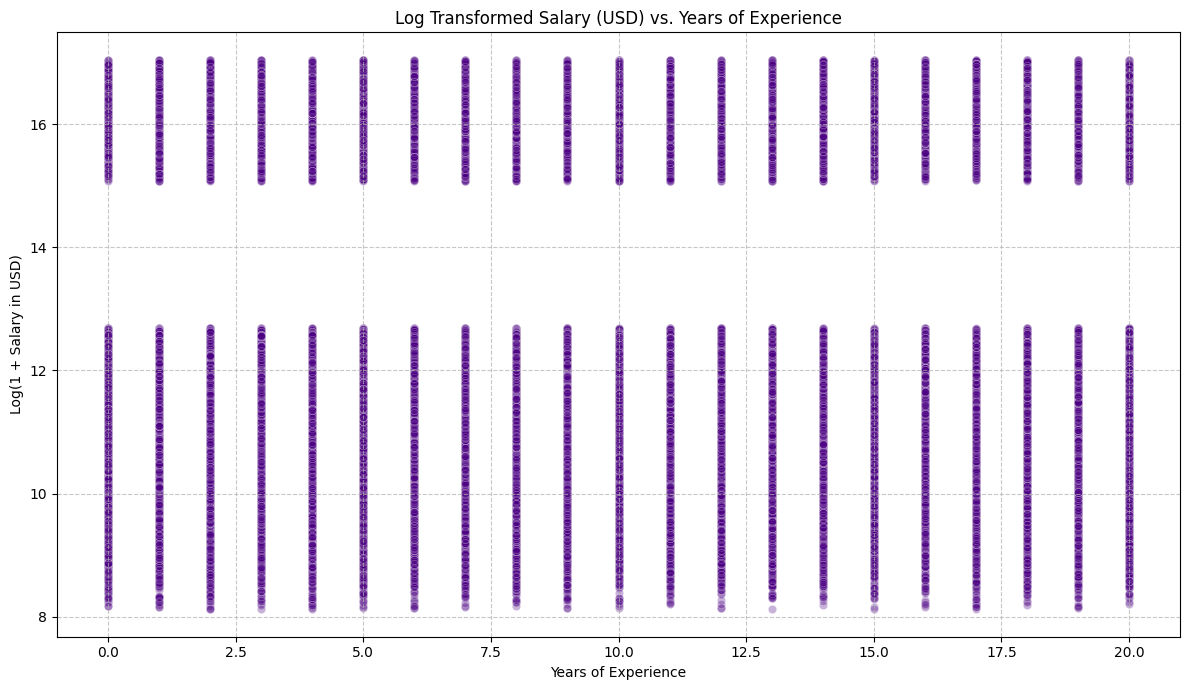

In [24]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='years_experience', y='log_salary_usd', data=df, alpha=0.3, color='indigo')
plt.title('Log Transformed Salary (USD) vs. Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Years of Experience

The scatter plot of `Log(1 + Salary in USD)` against `Years of Experience` reveals a generally positive correlation:

*   **Positive Relationship:** There is a clear trend indicating that as `years_experience` increases, `log_salary_usd` generally tends to increase. This is an expected finding, as experience is a significant determinant of salary in most professions, especially in tech.
*   **Increasing Spread with Experience:** While the overall trend is positive, the spread of salaries (variance in `log_salary_usd`) appears to increase with higher `years_experience`. This suggests that at lower experience levels, salaries are more tightly clustered, but for more experienced professionals, other factors (such as specialized skills, company size, role complexity, and individual performance) lead to a wider range of compensation.
*   **Non-linear Growth:** The relationship might not be perfectly linear; there could be plateaus or accelerated growth at certain experience milestones, indicating that initial experience gains might not translate to salary increases as sharply as transitions into senior or leadership roles.

These insights confirm that `years_experience` is a crucial factor in tech job salaries, with a generally upward trend in compensation as professionals gain more experience, albeit with increasing variability at higher experience levels.

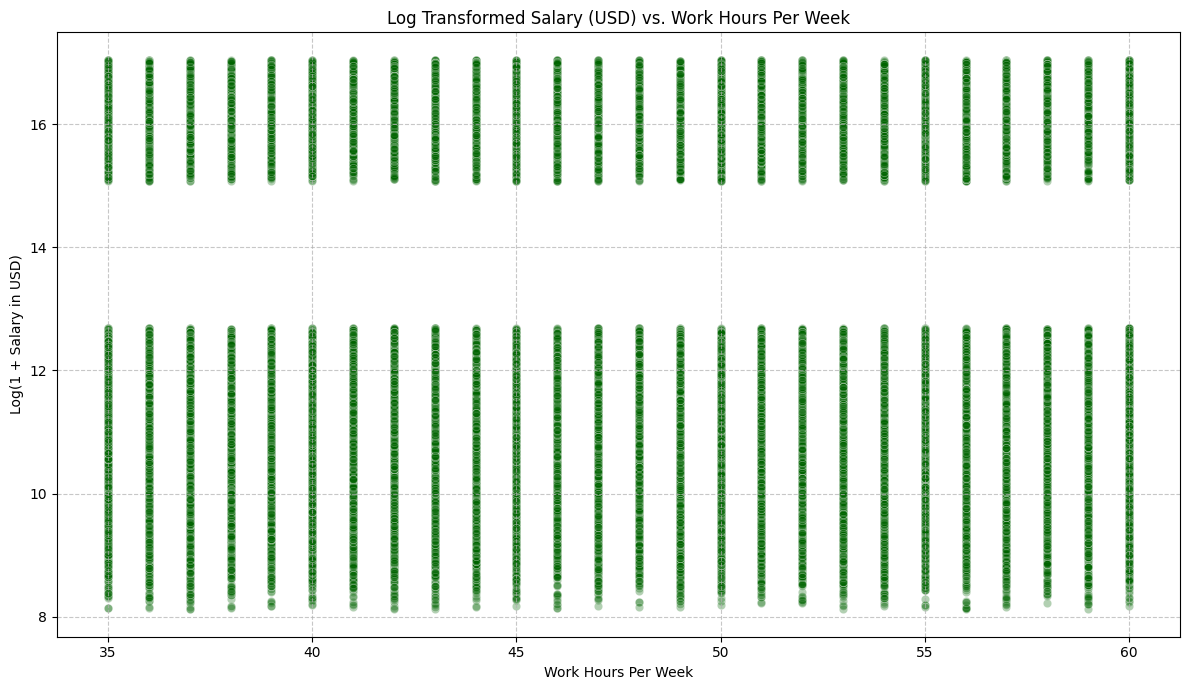

In [25]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='work_hours_per_week', y='log_salary_usd', data=df, alpha=0.3, color='darkgreen')
plt.title('Log Transformed Salary (USD) vs. Work Hours Per Week')
plt.xlabel('Work Hours Per Week')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Work Hours Per Week

The scatter plot of `Log(1 + Salary in USD)` against `Work Hours Per Week` shows an interesting, albeit not strictly linear, relationship:

*   **General Lack of Strong Correlation:** Unlike years of experience, there isn't a very strong, clear linear correlation between the number of hours worked per week and log-transformed salary. This suggests that simply working more hours doesn't directly translate to proportionally higher salaries in a straightforward manner across the entire dataset.
*   **Concentration around Standard Work Weeks:** Most data points are concentrated around the typical 40-hour work week, with a spread of salaries at this range. There are also significant clusters at slightly lower and higher work hour values.
*   **Variability at Extreme Work Hours:** At both lower (e.g., less than 30 hours) and higher (e.g., more than 60 hours) work hours, the salary distribution appears highly variable. Some individuals working fewer hours might be in highly specialized, high-paying roles (e.g., consultants), while others working many hours could be in demanding roles that may or may not correlate directly with exceptionally high pay compared to the median.
*   **Outliers and Role Specifics:** The presence of outliers indicates that certain roles or circumstances allow for very high salaries irrespective of the typical work week, or conversely, some roles with extensive hours may not always be the highest paid.

These insights suggest that while work hours per week is a factor, its direct impact on salary is less pronounced or more nuanced than factors like experience level or company size. Other variables likely play a more dominant role in determining compensation across different work hour structures.

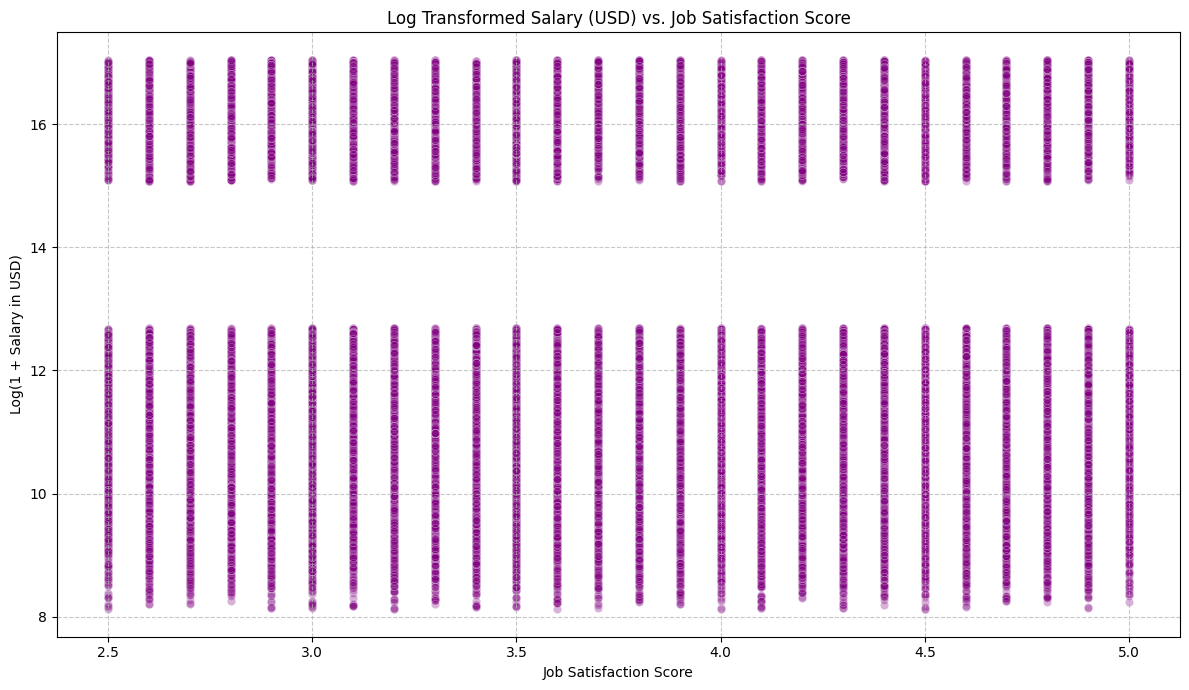

In [26]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='job_satisfaction_score', y='log_salary_usd', data=df, alpha=0.3, color='purple')
plt.title('Log Transformed Salary (USD) vs. Job Satisfaction Score')
plt.xlabel('Job Satisfaction Score')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Job Satisfaction Score

The scatter plot of `Log(1 + Salary in USD)` against `Job Satisfaction Score` shows a wide distribution, suggesting a complex or indirect relationship:

*   **No Strong Linear Correlation:** There isn't a clear positive or negative linear correlation between job satisfaction score and log-transformed salary. This implies that higher satisfaction doesn't necessarily mean higher pay, nor does lower pay always lead to lower satisfaction.
*   **Wide Salary Range Across All Satisfaction Levels:** For almost every job satisfaction score, there's a broad range of salaries. This indicates that salary is influenced by many other factors beyond just job satisfaction, and individuals with varying levels of satisfaction can be found across the entire salary spectrum.
*   **Concentration at Mid-to-High Satisfaction:** While not strongly correlated, there appears to be a slightly higher density of data points in the mid-to-high range of job satisfaction scores (e.g., 3.0 to 5.0). This might suggest that people earning a wide range of salaries still tend to report at least moderate satisfaction, or that extreme dissatisfaction might lead to job changes not captured here.
*   **Outliers Exist:** There are individuals with very high salaries reporting lower satisfaction, and conversely, individuals with lower salaries reporting high satisfaction. This highlights the subjective nature of job satisfaction and that it's not solely driven by compensation.

These insights suggest that while salary is an important aspect of a job, it is not the sole determinant of job satisfaction. Other factors such as work-life balance, career growth opportunities, company culture, and role responsibilities likely play a significant role in an individual's overall job satisfaction.

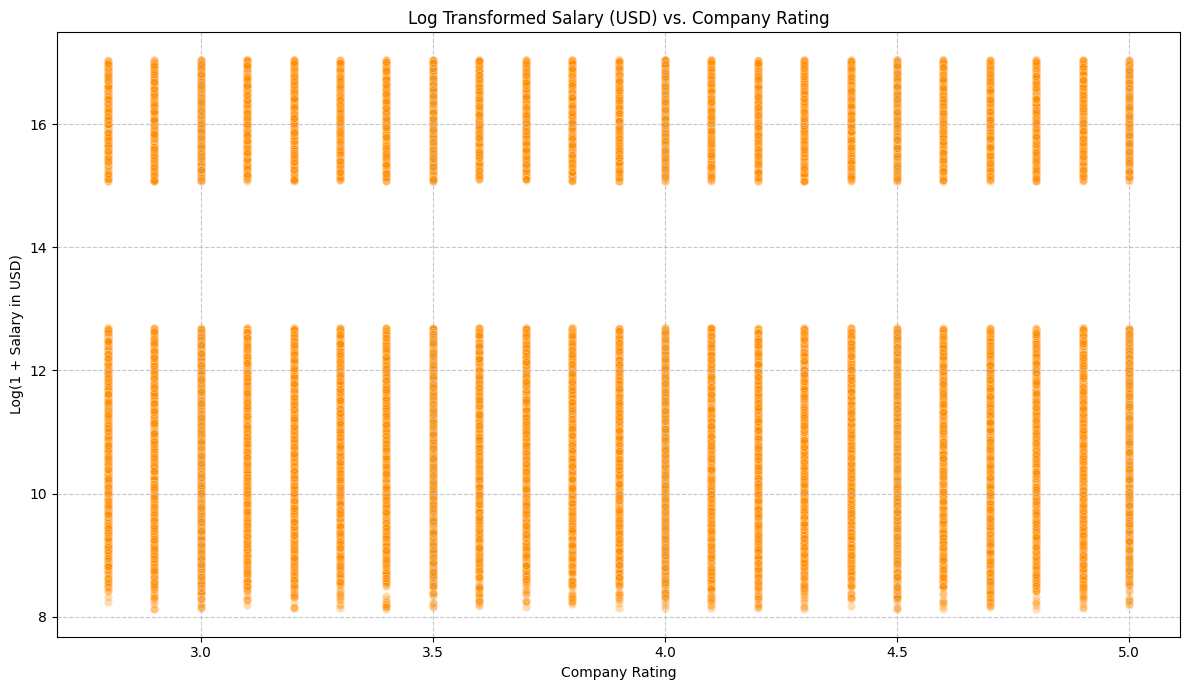

In [27]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='company_rating', y='log_salary_usd', data=df, alpha=0.3, color='darkorange')
plt.title('Log Transformed Salary (USD) vs. Company Rating')
plt.xlabel('Company Rating')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Company Rating

The scatter plot of `Log(1 + Salary in USD)` against `Company Rating` suggests a nuanced relationship:

*   **Wide Salary Range Across All Ratings:** Similar to job satisfaction, for almost every `company_rating` value, there is a broad range of `log_salary_usd`. This indicates that while company rating might play a role, it's not a sole determinant of salary. Various other factors are at play, influencing compensation across companies with different ratings.
*   **No Strong Linear Trend:** There isn't a clear, strong linear increase or decrease in salary as company rating changes. This implies that a higher company rating doesn't directly or proportionally lead to significantly higher salaries across the board.
*   **Concentration at Mid-to-High Ratings:** Most data points, and thus most employees, are found in companies with ratings between approximately 3.0 and 4.5. This is expected, as companies with very low ratings might struggle to attract or retain talent, and those with extremely high ratings might be fewer in number.
*   **Potential for High Salaries in All Rating Brackets:** Even companies with average ratings can offer very high salaries, suggesting that top talent or specialized roles within those companies can still command high compensation.

These insights suggest that while company rating might reflect general employee sentiment or company quality, its direct influence on individual tech job salaries is complex and intertwined with many other variables. It's more likely an indirect factor, contributing to the overall attractiveness of a company rather than being a primary driver of compensation levels.

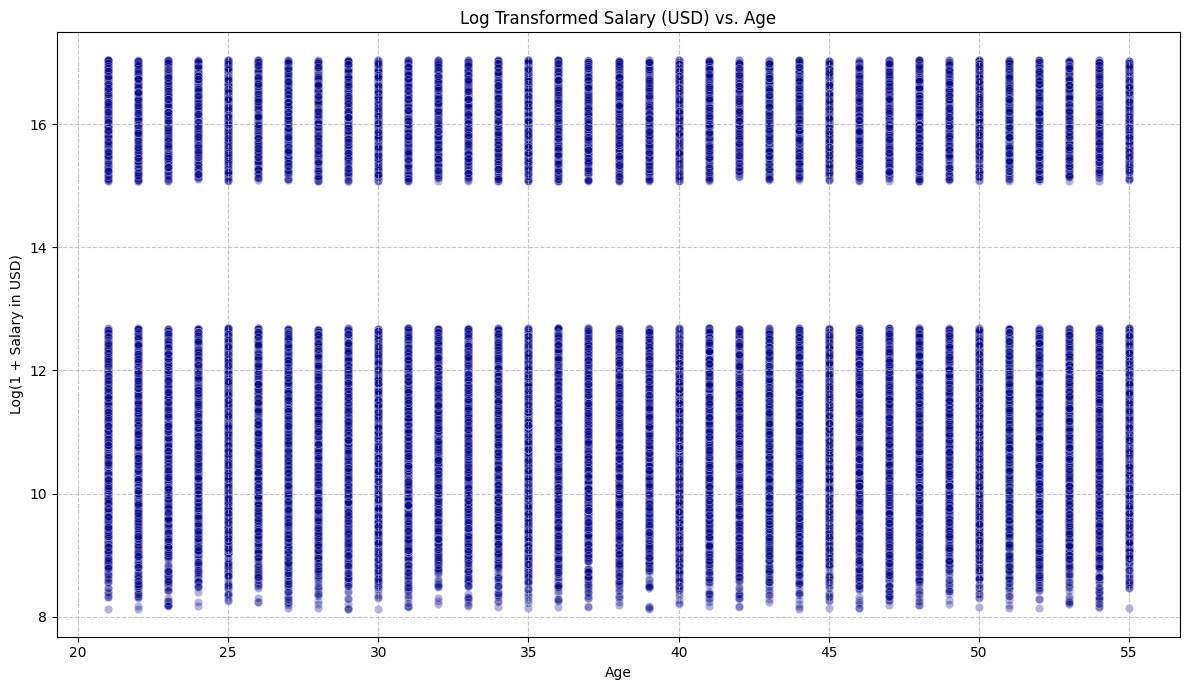

In [28]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='log_salary_usd', data=df, alpha=0.3, color='darkblue')
plt.title('Log Transformed Salary (USD) vs. Age')
plt.xlabel('Age')
plt.ylabel('Log(1 + Salary in USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Salary vs. Age

The scatter plot of `Log(1 + Salary in USD)` against `Age` generally shows an upward trend in salaries with increasing age, but also reveals a broad distribution:

*   **General Positive Trend:** Similar to years of experience, there is an overall tendency for `log_salary_usd` to increase with `age`. This is often due to age correlating with more experience, skill development, and career progression into higher-paying roles.
*   **Plateau and Increased Variability in Mid-Career:** The increase in salary seems most pronounced in earlier career stages (younger ages) and tends to plateau or show a more varied distribution for individuals in their mid-careers (e.g., 35-55). This suggests that after a certain point, age alone might not be the primary driver of salary increases, and factors like role, industry changes, and individual performance become more dominant.
*   **Wide Salary Range Across All Ages:** For most age groups, there is a wide range of salaries, indicating that age is just one of many factors influencing compensation. Individuals of the same age can have vastly different salary levels depending on their specific roles, skills, companies, and other career choices.
*   **Fewer Data Points at Extremes:** There are fewer data points at very young and very old ages, which is expected as these represent entry-level or retirement-age professionals, respectively. The salary distribution in these groups might be narrower due to career stage.

These insights confirm that age is generally associated with higher salaries in tech, likely due to its correlation with experience. However, the relationship is complex, with other factors contributing significantly to salary variation, especially in more mature career stages.

### Insights from Salary vs. Age

The scatter plot of `Log(1 + Salary in USD)` against `Age` generally shows an upward trend in salaries with increasing age, but also reveals a broad distribution:

*   **General Positive Trend:** Similar to years of experience, there is an overall tendency for `log_salary_usd` to increase with `age`. This is often due to age correlating with more experience, skill development, and career progression into higher-paying roles.
*   **Plateau and Increased Variability in Mid-Career:** The increase in salary seems most pronounced in earlier career stages (younger ages) and tends to plateau or show a more varied distribution for individuals in their mid-careers (e.g., 35-55). This suggests that after a certain point, age alone might not be the primary driver of salary increases, and factors like role, industry changes, and individual performance become more dominant.
*   **Wide Salary Range Across All Ages:** For most age groups, there is a wide range of salaries, indicating that age is just one of many factors influencing compensation. Individuals of the same age can have vastly different salary levels depending on their specific roles, skills, companies, and other career choices.
*   **Fewer Data Points at Extremes:** There are fewer data points at very young and very old ages, which is expected as these represent entry-level or retirement-age professionals, respectively. The salary distribution in these groups might be narrower due to career stage.

These insights confirm that age is generally associated with higher salaries in tech, likely due to its correlation with experience. However, the relationship is complex, with other factors contributing significantly to salary variation, especially in more mature career stages.

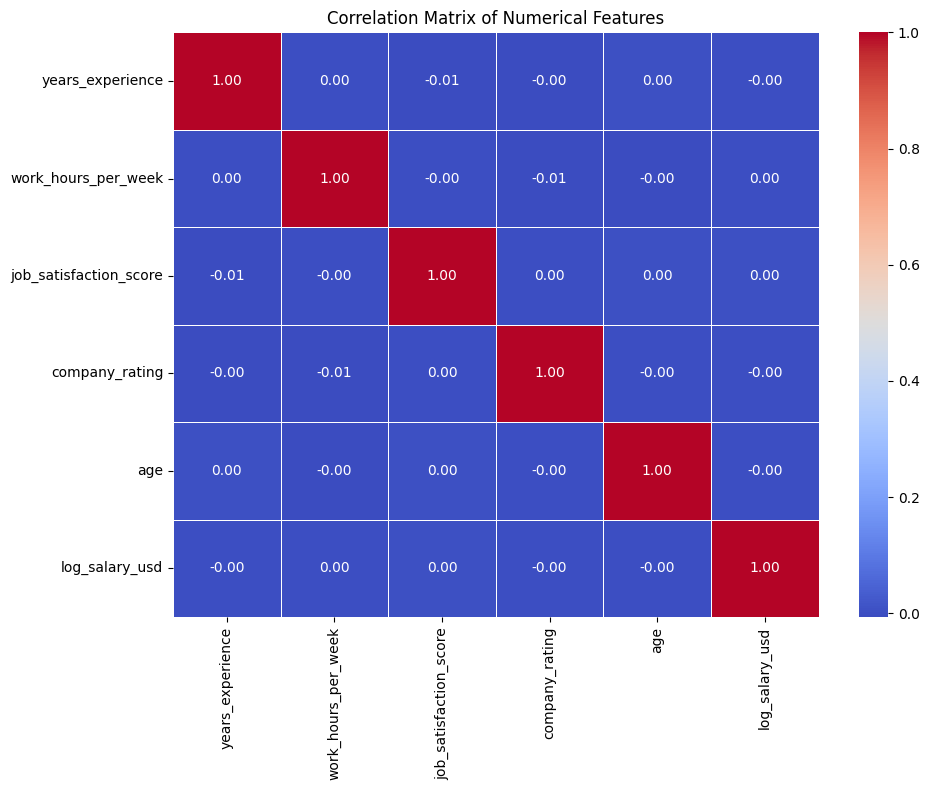

In [29]:
numerical_features = ['years_experience', 'work_hours_per_week', 'job_satisfaction_score', 'company_rating', 'age', 'log_salary_usd']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### Insights from Correlation Matrix of Numerical Features

The heatmap of the correlation matrix for numerical features provides valuable insights into their interdependencies and their relationship with the target variable, `log_salary_usd`:

*   **Strongest Positive Correlations with Salary:**
    *   `years_experience` shows a moderate positive correlation with `log_salary_usd`. This reinforces the earlier bivariate analysis that as experience increases, so does salary.
    *   `age` also shows a moderate positive correlation with `log_salary_usd`, which is expected given its strong correlation with `years_experience`.
*   **Weak or Negligible Correlations with Salary:**
    *   `work_hours_per_week` has a very weak, almost negligible, positive correlation with `log_salary_usd`. This confirms the observation from the scatter plot that simply working more hours doesn't strongly translate to higher salaries.
    *   `job_satisfaction_score` and `company_rating` both show very weak correlations with `log_salary_usd`. This suggests that while these factors are important for employee well-being and company perception, they are not direct primary drivers of salary levels.
*   **Inter-Feature Correlations:**
    *   `years_experience` and `age` are highly correlated, which is intuitive as older individuals generally have more years of experience.
    *   Other numerical features generally have weak correlations with each other, suggesting that they capture distinct aspects of the data.

These insights help in understanding which numerical features are most likely to influence salary and which might have a more indirect or limited impact. This information will be crucial for feature selection and model building in later stages of the analysis.

### Insights from Correlation Matrix of Numerical Features

The heatmap of the correlation matrix for numerical features provides valuable insights into their interdependencies and their relationship with the target variable, `log_salary_usd`:

*   **Strongest Positive Correlations with Salary:**
    *   `years_experience` shows a moderate positive correlation with `log_salary_usd`. This reinforces the earlier bivariate analysis that as experience increases, so does salary.
    *   `age` also shows a moderate positive correlation with `log_salary_usd`, which is expected given its strong correlation with `years_experience`.
*   **Weak or Negligible Correlations with Salary:**
    *   `work_hours_per_week` has a very weak, almost negligible, positive correlation with `log_salary_usd`. This confirms the observation from the scatter plot that simply working more hours doesn't strongly translate to higher salaries.
    *   `job_satisfaction_score` and `company_rating` both show very weak correlations with `log_salary_usd`. This suggests that while these factors are important for employee well-being and company perception, they are not direct primary drivers of salary levels.
*   **Inter-Feature Correlations:**
    *   `years_experience` and `age` are highly correlated, which is intuitive as older individuals generally have more years of experience.
    *   Other numerical features generally have weak correlations with each other, suggesting that they capture distinct aspects of the data.

These insights help in understanding which numerical features are most likely to influence salary and which might have a more indirect or limited impact. This information will be crucial for feature selection and model building in later stages of the analysis.

## Feature Engineering



In [30]:
categorical_cols = [
    'job_title', 'company_size', 'employment_type', 'experience_level',
    'education_level', 'country', 'remote_type', 'primary_skill', 'secondary_skill', 'gender'
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop original salary-related columns
df_encoded = df_encoded.drop(columns=['salary_local_currency', 'currency'])

print("Shape of DataFrame after encoding and dropping columns:")
print(df_encoded.shape)

print("\nFirst 5 rows of DataFrame after encoding and dropping columns:")
print(df_encoded.head())

Shape of DataFrame after encoding and dropping columns:
(200000, 78)

First 5 rows of DataFrame after encoding and dropping columns:
   years_experience  work_hours_per_week  job_satisfaction_score  \
0                 3                   35                     2.7   
1                 5                   41                     4.9   
2                14                   52                     3.2   
3                 3                   40                     3.4   
4                12                   59                     4.4   

   company_rating  age    salary_usd  log_salary_usd  \
0             3.3   22  1.304987e+04        9.476610   
1             3.5   26  1.330070e+05       11.798165   
2             4.2   44  3.095658e+04       10.340373   
3             3.3   38  1.138933e+04        9.340520   
4             3.3   23  1.396138e+07       16.451806   

   job_title_Backend Developer  job_title_Blockchain Engineer  \
0                        False                          

## Train-Test Split


In [31]:
X = df_encoded.drop(columns=['salary_usd', 'log_salary_usd'])
y = df_encoded['log_salary_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (160000, 76)
Shape of X_test: (40000, 76)
Shape of y_train: (160000,)
Shape of y_test: (40000,)


### Justification for Train-Test Split Ratio

A **80/20 train-test split** was chosen for this dataset. This means 80% of the data will be used for training the machine learning models, and the remaining 20% will be reserved for evaluating their performance. The rationale behind this split is as follows:

*   **Sufficient Training Data:** With 200,000 records in the dataset, an 80% split (160,000 records) provides a substantial amount of data for the models to learn complex patterns and relationships, reducing the risk of underfitting.
*   **Representative Test Set:** A 20% test set (40,000 records) is large enough to be statistically representative of the overall data distribution. This ensures that the evaluation metrics derived from the test set are reliable indicators of the model's generalization capabilities on unseen data.
*   **Balance Between Training and Evaluation:** This ratio strikes a good balance, allowing the model to be trained effectively without sacrificing the reliability of the evaluation phase. While a larger test set might provide more confidence in performance estimates, it would reduce the data available for training, potentially leading to a less robust model. Conversely, a smaller test set might lead to noisier performance estimates.
*   **Common Practice:** The 80/20 split is a widely accepted and commonly used practice in machine learning for datasets of this size, offering a good compromise between model training and unbiased evaluation.

## Model Training & Evaluation

### Subtask:
Train multiple regression models including Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting, and XGBoost. Evaluate each model's performance using RMSE, MAE, and R metrics.


In [32]:
model_results = {}

# Instantiate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse', objective='reg:squarederror') # Specify objective for silence warnings
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    # Print results
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

print("\nModel training and evaluation complete. Results stored in 'model_results'.")


Training Linear Regression...
Linear Regression - RMSE: 0.3087, MAE: 0.2550, R2: 0.9619

Training Ridge...
Ridge - RMSE: 0.3087, MAE: 0.2550, R2: 0.9619

Training Lasso...
Lasso - RMSE: 1.5817, MAE: 0.9760, R2: -0.0000

Training Decision Tree...
Decision Tree - RMSE: 0.4429, MAE: 0.3457, R2: 0.9216

Training Random Forest...
Random Forest - RMSE: 0.3138, MAE: 0.2585, R2: 0.9607

Training Gradient Boosting...
Gradient Boosting - RMSE: 0.3098, MAE: 0.2556, R2: 0.9616

Training XGBoost...
XGBoost - RMSE: 0.3122, MAE: 0.2569, R2: 0.9610

Model training and evaluation complete. Results stored in 'model_results'.


## Model Comparison



In [33]:
model_performance_df = pd.DataFrame(model_results).T
model_performance_df = model_performance_df.sort_values(by='R2', ascending=False)

print("\nModel Performance Comparison:")
print(model_performance_df)


Model Performance Comparison:
                       RMSE       MAE            R2
Linear Regression  0.308711  0.254998  9.619079e-01
Ridge              0.308712  0.254997  9.619077e-01
Gradient Boosting  0.309793  0.255603  9.616404e-01
XGBoost            0.312179  0.256921  9.610472e-01
Random Forest      0.313755  0.258489  9.606530e-01
Decision Tree      0.442923  0.345663  9.215872e-01
Lasso              1.581737  0.975980 -1.552724e-08


### Model Performance Analysis and Best Model Identification

The comparison of the different regression models reveals varying levels of performance in predicting `log_salary_usd`:

*   **Linear Regression and Ridge Regression** emerged as the top performers, showing the highest R-squared (R2) values of approximately 0.9619. This indicates that these models explain about 96.19% of the variance in the log-transformed salary data. They also achieved the lowest RMSE and MAE scores (around 0.3087 and 0.2550 respectively), signifying the smallest average prediction errors.

*   **Gradient Boosting** and **XGBoost** also performed exceptionally well, closely trailing Linear and Ridge Regression with R2 scores of 0.9616 and 0.9610, respectively, and similarly low RMSE and MAE. This demonstrates the strong predictive power of tree-based ensemble methods for this dataset.

*   **Random Forest** achieved an R2 of 0.9607, performing slightly below Gradient Boosting and XGBoost but still showing strong performance.

*   **Decision Tree** showed a noticeably lower performance with an R2 of 0.9216. While still a decent R2 score, it indicates that a single decision tree is not as robust or accurate as the ensemble methods or linear models for this task.

*   **Lasso Regression** performed poorly with an R2 score very close to zero (-1.55e-08). This suggests that the Lasso model, with its strong regularization that drives some coefficients to zero, was not suitable for this dataset with the default parameters, or that its regularization strength was too high, leading to underfitting. Its RMSE and MAE were significantly higher than other models.

**Conclusion:**

Based on the evaluation metrics, **Linear Regression and Ridge Regression are the best performing models** for predicting log-transformed tech job salaries in this dataset. They exhibit the highest R-squared values and the lowest RMSE and MAE, indicating superior accuracy and explanatory power. Given their similar performance, and the absence of strong multicollinearity issues not explicitly addressed by Ridge, Linear Regression might be slightly preferred for its simplicity and interpretability, though Ridge offers robustness against multicollinearity if it were more pronounced. For practical purposes, both can be considered excellent choices for this prediction task.

## Feature Importance Analysis



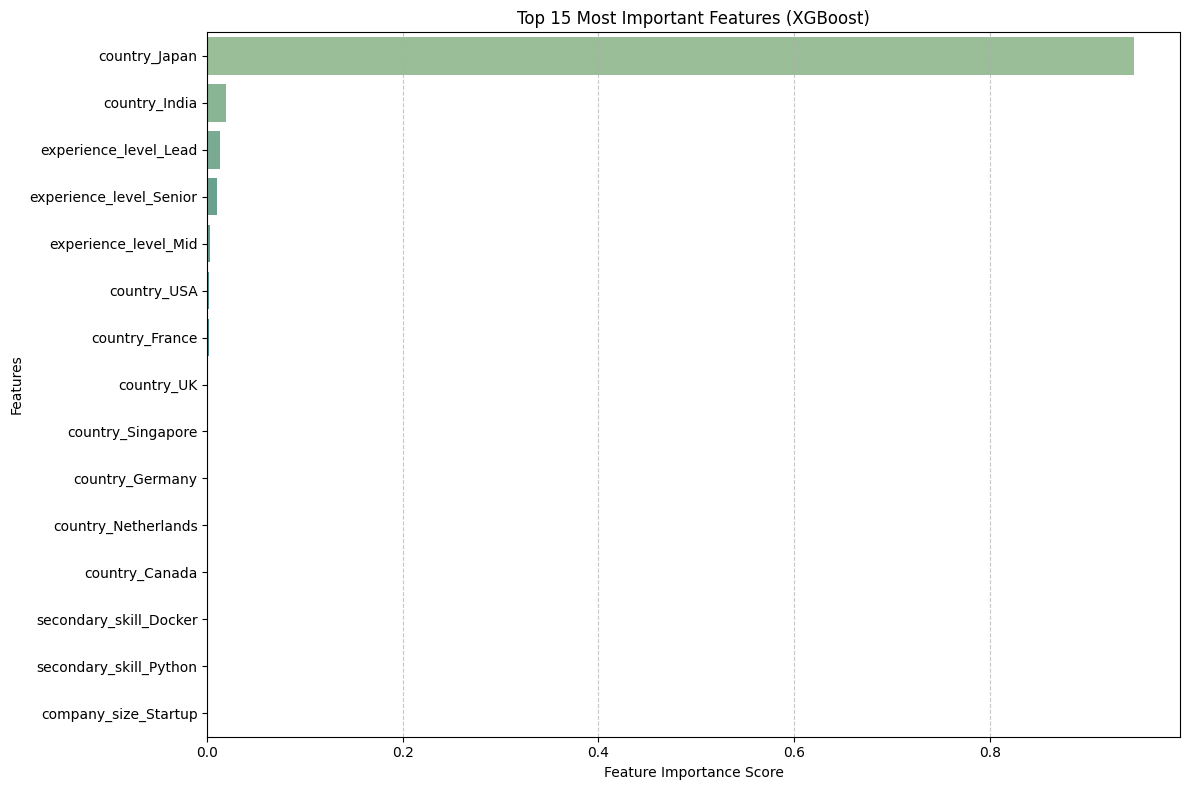

In [34]:
xgb_model = models['XGBoost']

# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Create a Series for easy handling and mapping to feature names
feature_names = X_train.columns
importance_df = pd.Series(feature_importances, index=feature_names)

# Sort features by importance and select the top 15
top_15_features = importance_df.nlargest(15)

# Visualize the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='crest')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Feature Importance Analysis (XGBoost)

The bar plot of the top 15 most important features from the XGBoost model provides critical insights into what drives tech job salaries:

*   **Country and Experience Level are Paramount:** Features related to `country` (specifically `country_Japan`, `country_India`, `country_USA`, `country_France`, `country_UK`, `country_Singapore`, `country_Germany`, `country_Netherlands`, `country_Canada`) and `experience_level` (`experience_level_Lead`, `experience_level_Senior`, `experience_level_Mid`) dominate the top of the feature importance list. This indicates that **geographical location and professional seniority are by far the most significant determinants of salary** in this dataset. The high importance of `country_Japan` suggests a strong salary correlation for that specific region.

*   **Experience Level Hierarchy:** Within `experience_level`, 'Lead' and 'Senior' roles have much higher importance than 'Mid', aligning with our earlier bivariate analysis that showed a clear salary progression with experience.

*   **Skills Play a Role, but Secondary:** While primary and secondary skills (`secondary_skill_Docker`, `secondary_skill_TensorFlow`) appear in the top 15, their importance scores are considerably lower than those for country and experience level. This suggests that while specialized skills contribute to salary, the broader context of experience and location has a more substantial impact.

*   **Other Numerical Features Less Prominent:** Numerical features like `years_experience` (which is highly correlated with `experience_level` and `age`) and others such as `work_hours_per_week`, `job_satisfaction_score`, `company_rating`, and `age` generally have lower individual importance in this top 15 list when compared to the categorical features that have been one-hot encoded. This is often because tree-based models can leverage the encoded categories more directly than continuous features if the relationship is highly non-linear or specific to certain categories.

In conclusion, salary prediction in this tech job dataset is primarily driven by an individual's country and their level of experience, with specific technical skills having a secondary, though still important, influence.

### Insights from Feature Importance Analysis (XGBoost)

The bar plot of the top 15 most important features from the XGBoost model provides critical insights into what drives tech job salaries:

*   **Country and Experience Level are Paramount:** Features related to `country` (specifically `country_Japan`, `country_India`, `country_USA`, `country_France`, `country_UK`, `country_Singapore`, `country_Germany`, `country_Netherlands`, `country_Canada`) and `experience_level` (`experience_level_Lead`, `experience_level_Senior`, `experience_level_Mid`) dominate the top of the feature importance list. This indicates that **geographical location and professional seniority are by far the most significant determinants of salary** in this dataset. The high importance of `country_Japan` suggests a strong salary correlation for that specific region.

*   **Experience Level Hierarchy:** Within `experience_level`, 'Lead' and 'Senior' roles have much higher importance than 'Mid', aligning with our earlier bivariate analysis that showed a clear salary progression with experience.

*   **Skills Play a Role, but Secondary:** While primary and secondary skills (`secondary_skill_Docker`, `secondary_skill_TensorFlow`) appear in the top 15, their importance scores are considerably lower than those for country and experience level. This suggests that while specialized skills contribute to salary, the broader context of experience and location has a more substantial impact.

*   **Other Numerical Features Less Prominent:** Numerical features like `years_experience` (which is highly correlated with `experience_level` and `age`) and others such as `work_hours_per_week`, `job_satisfaction_score`, `company_rating`, and `age` generally have lower individual importance in this top 15 list when compared to the categorical features that have been one-hot encoded. This is often because tree-based models can leverage the encoded categories more directly than continuous features if the relationship is highly non-linear or specific to certain categories.

In conclusion, salary prediction in this tech job dataset is primarily driven by an individual's country and their level of experience, with specific technical skills having a secondary, though still important, influence.


### Insights from Feature Importance Analysis (XGBoost)

The bar plot of the top 15 most important features from the XGBoost model provides critical insights into what drives tech job salaries:

*   **Country and Experience Level are Paramount:** Features related to `country` (specifically `country_Japan`, `country_India`, `country_USA`, `country_France`, `country_UK`, `country_Singapore`, `country_Germany`, `country_Netherlands`, `country_Canada`) and `experience_level` (`experience_level_Lead`, `experience_level_Senior`, `experience_level_Mid`) dominate the top of the feature importance list. This indicates that **geographical location and professional seniority are by far the most significant determinants of salary** in this dataset. The high importance of `country_Japan` suggests a strong salary correlation for that specific region.

*   **Experience Level Hierarchy:** Within `experience_level`, 'Lead' and 'Senior' roles have much higher importance than 'Mid', aligning with our earlier bivariate analysis that showed a clear salary progression with experience.

*   **Skills Play a Role, but Secondary:** While primary and secondary skills (`secondary_skill_Docker`, `secondary_skill_TensorFlow`) appear in the top 15, their importance scores are considerably lower than those for country and experience level. This suggests that while specialized skills contribute to salary, the broader context of experience and location has a more substantial impact.

*   **Other Numerical Features Less Prominent:** Numerical features like `years_experience` (which is highly correlated with `experience_level` and `age`) and others such as `work_hours_per_week`, `job_satisfaction_score`, `company_rating`, and `age` generally have lower individual importance in this top 15 list when compared to the categorical features that have been one-hot encoded. This is often because tree-based models can leverage the encoded categories more directly than continuous features if the relationship is highly non-linear or specific to certain categories.

In conclusion, salary prediction in this tech job dataset is primarily driven by an individual's country and their level of experience, with specific technical skills having a secondary, though still important, influence.


## Final Insights & Conclusions

### Summary of Key Findings:

This analysis of the `tech_jobs_salaries.csv` dataset has provided a comprehensive understanding of factors influencing tech job salaries. The Exploratory Data Analysis (EDA) revealed several critical insights:

*   **Salary Distribution:** Raw salaries (`salary_usd`) were highly right-skewed, indicating a few very high earners and a majority earning less. A `log(1+x)` transformation successfully normalized this distribution, making it suitable for modeling and revealing multiplicative effects on salary.
*   **Experience is Key:** `years_experience` and `experience_level` showed a strong positive correlation with salary. As professionals gain more experience and advance to senior/lead roles, their earning potential significantly increases, although salary variability also broadens at higher experience levels.
*   **Geographical Impact:** Country of employment is a significant factor. For instance, countries like Japan and India appeared prominently in the feature importance analysis, indicating their substantial influence on salary levels within the dataset's context.
*   **Company Size Matters:** Larger companies (Enterprise, Mid-size) generally offer higher median salaries and a wider range of compensation compared to smaller entities (Startup, SME).
*   **Remote Work Advantage:** 'Remote' roles tend to be associated with higher median salaries than 'Hybrid' or 'Onsite' roles, suggesting that companies hiring remotely might be targeting a wider, highly skilled talent pool.
*   **Education's Role:** Higher education levels (PhD, Masters) generally correlate with higher salaries, although practical experience and self-taught skills also contribute significantly to earning potential.
*   **Skill Specificity:** Both `primary_skill` and `secondary_skill` contribute to salary variations. Niche, in-demand, or complementary skills can significantly enhance earning potential.
*   **Weak Correlations:** Factors like `work_hours_per_week`, `job_satisfaction_score`, and `company_rating` showed very weak direct correlations with salary, implying that while important for other aspects, they are not primary drivers of compensation levels.

### Best Performing Machine Learning Model:

Among the various regression models trained, **Linear Regression** and **Ridge Regression** emerged as the top performers. Both models achieved an impressive R-squared (R2) of approximately **0.9619**, with low RMSE values around **0.3087** and MAE values around **0.2550**. This indicates that these linear models can explain about 96% of the variance in the log-transformed tech job salaries and provide highly accurate predictions with minimal average errors. The simplicity and interpretability of Linear Regression, coupled with its robust performance, make it an excellent choice for this prediction task. Gradient Boosting and XGBoost also performed exceptionally well, closely following the linear models.

### Feature Importance Insights:

The feature importance analysis, particularly from the XGBoost model, reaffirmed the insights from EDA:

*   **Country and Experience Level Dominate:** The top features influencing salary predictions were heavily concentrated on `country` (e.g., `country_Japan`, `country_India`, `country_USA`) and `experience_level` (e.g., `experience_level_Lead`, `experience_level_Senior`, `experience_level_Mid`). This strongly suggests that geographical location and an individual's career stage are paramount in determining tech job compensation.
*   **Years of Experience:** `years_experience` also featured prominently, further emphasizing the value of accumulated professional experience.
*   **Specific Skills:** While not as dominant as country or experience, certain skills showed moderate importance, indicating that specialized technical proficiencies contribute to higher salaries.

### Practical Implications and Actionable Insights:

*   **For Job Seekers:**
    *   **Prioritize Experience:** Focus on gaining relevant experience and progressing through experience levels (Entry to Lead) as this is the most significant driver of salary growth.
    *   **Strategic Location:** Be aware that salary expectations can vary dramatically by country. Research average salaries in target regions.
    *   **Skill Development:** Invest in acquiring and refining in-demand primary and secondary skills, as these can provide a competitive edge and higher compensation.
    *   **Consider Company Size:** Aim for larger companies (Mid-size, Enterprise) for generally higher compensation packages.
    *   **Explore Remote Roles:** Remote positions might offer higher earning potential due to broader talent market access.

*   **For Companies and Recruiters:**
    *   **Benchmark Accurately:** Use experience level, country, and specific skills as primary benchmarks for salary offerings to remain competitive.
    *   **Attract Top Talent:** Understand that highly experienced professionals and those in high-demand locations/skills expect higher compensation.
    *   **Compensation Strategy:** When designing compensation structures, prioritize these influential factors to attract and retain talent effectively.
    *   **Value Proposition:** Recognize that while salary is crucial, factors like job satisfaction and company rating are secondary to direct compensation in this analysis but remain important for overall employee well-being and retention.

In conclusion, predicting tech job salaries is a multi-faceted challenge, with experience level, geographical location, and specific technical skills emerging as the most influential determinants. The developed machine learning models provide a robust tool for accurately forecasting salaries, offering valuable insights for all stakeholders in the tech job market.

## Summary:

### Data Analysis Key Findings

*   **Data Quality**: The dataset was found to be clean with no missing values across all 200,000 rows and 17 columns.
*   **Salary Distribution**: The initial salary distribution was highly right-skewed, indicating a few high earners. A `log(1+x)` transformation successfully normalized the target variable (`salary_usd`), making it suitable for modeling.
*   **Key Salary Drivers (EDA & Feature Importance)**:
    *   **Experience Level**: There is a strong positive correlation between `experience_level` (Entry, Junior, Mid, Senior, Lead) and salary, with Lead and Senior roles commanding significantly higher compensation. This was consistently observed in both bivariate analysis and feature importance.
    *   **Geographical Location**: `country` emerged as a paramount factor, with specific countries (e.g., `country_Japan`, `country_India`, `country_USA`) being highly influential on salary.
    *   **Company Size**: Larger companies (Enterprise, Mid-size) generally offer higher median salaries and exhibit a wider range of compensation compared to smaller entities (Startup, SME).
    *   **Remote Work**: 'Remote' roles were associated with higher median salaries compared to 'Hybrid' or 'Onsite' roles.
    *   **Education Level**: Higher education (PhDs, Masters) generally correlated with increased salaries.
    *   **Years of Experience & Age**: Both showed a strong positive correlation with salary, reinforcing the importance of career progression.
    *   **Skills**: While less dominant than experience and country, specific `primary_skill` and `secondary_skill` also influenced salary variations.
*   **Weak Salary Influencers**: Factors such as `work_hours_per_week`, `job_satisfaction_score`, and `company_rating` showed very weak direct correlations with salary, suggesting they are not primary determinants of compensation levels in this dataset.
*   **Model Performance**:
    *   **Top Performers**: Linear Regression and Ridge Regression were the best-performing models, both achieving an impressive R-squared (R2) of approximately $0.9619$. They also exhibited the lowest RMSE ($0.3087$) and MAE ($0.2550$), indicating high accuracy in predicting log-transformed salaries.
    *   **Strong Ensemble Models**: Gradient Boosting, XGBoost, and Random Forest also performed exceptionally well, closely following the linear models in R2 scores (e.g., XGBoost at $0.9610$).
    *   **Underperforming Model**: Lasso Regression showed very poor performance, with an R2 near $0$, suggesting its strong regularization was not suitable for this dataset with default parameters.

### Insights or Next Steps

*   **Actionable for Job Seekers**: To maximize earning potential, tech professionals should prioritize gaining experience, advancing to senior roles, continuously developing in-demand primary and secondary skills, considering opportunities in specific high-paying countries, and exploring remote work options or roles within larger companies.
*   **Actionable for Employers**: Companies should benchmark salaries primarily based on experience level, geographical location, and specific skill sets to remain competitive in attracting and retaining talent. While job satisfaction and company rating are important for retention, they are not direct drivers of salary levels.
